In [1]:
%env JAX_PLATFORM_NAME=cpu

import jax
import jax.numpy as jnp
from morphomatics.manifold import Sphere, TangentBundle, Manifold

# time points sampled to visualize geodesics
t = jnp.linspace(0, 1, 25)

env: JAX_PLATFORM_NAME=cpu


# Sasaki Metric and Applications in Geodesic Analysis

Authors: Felix Ambellan, Martin Hanik, Dr. Esfandiar Nava-Yazdani, and Dr. Christoph von Tycowicz

## 1. Introduction and motivation
An important problem in statistics is the analysis of longitudinal data, which is collected, most prominently, in many medical studies. Thereby, one _repeatedly_ observes the same individuals to collect changes that might occur over a period of time. Such data poses challenges because fundamental independency assumptions, which many statistical procedures presuppose, are violated: While it is often reasonable to assume that observations from different individuals are independent, this is quite certainly wrong when they come from the same subject---especially when not too much time passed between them.
Much research has focussed on the correct analysis of multivariate longitudinal data, and, in recent years, several of the resulting methods have been generalized to manifold-valued longitudinal data with success.

Amongst others, _hierarchical models_ that rely on geodesics were formulated. They split the analysis of (local-enough) data up into the following two consecutive steps:

 * In the first step, each subject's trend is captured independently via geodesic regression. Thereby, correlated samples are dealt with exclusively.
 * In the second step, group-wise analysis (e.g., computation of a mean geodesic, covariance analysis of trends) of the subject-specific geodesics can be performed with standard (Riemannain geometric) tools, because the computed trends are (usually) independent again.

In order to perform statistical analysis of geodesics, we need to turn the ''space of geodesics'' into a Riemannian manifold. This can be done as follows: Let $M$ be the underlying Riemannian manifold (the manifold in which the data lies), $g$ its metric, and $TM$ its tangent bundle. Further, let $\gamma: [0,1] \to M$ be a geodesic. Because $\gamma$ is uniquely determined by its starting point and initial velocity, i.e., by an element $(p,v) \in TM$, we can _identify_ it with the latter element of $TM$. In other words, we can identify the space of geodesics with (a part of) the tangent bundle.

Now, it is a well-known fact that the tangent bundle $TM$ of a smooth Riemannian manifold is also a smooth manifold. As such it can be endowed with a Riemannian structure. A very natural choice of metric (which is now defined on $TTM$) is the _Sasaki metric_ named after its discoverer [Shigeo Sasaki](https://mathshistory.st-andrews.ac.uk/Biographies/Sasaki/); it is characterized by the following three properties:

* the projection $\pi$ of $TM$ onto $M$ given by $(p,v) \mapsto p$ is a [Riemannian submersion](https://en.wikipedia.org/wiki/Riemannian_submersion),
* tangent vectors of parallel vector fields $X(t)$ along curves $p(t)$ in $M$ (which, as $t \mapsto (p(t), X(t))$, are curves in $TM$) are orthogonal to fibres (i.e., to tangent vectors of curves $t \mapsto (p, Y(t)) \in TM$ with fixed footpoint),
* its restriction to any tangent space $T_pM \subset TM$ is the Euclidean metric introduced there by $g$.

This metric (together with its corresponding Levi-Civita connection) can be used for statistics in $TM$ and, thus, in the second step of the hierarchical model outlined above; this was first proposed by Muralidharan and Fletcher (see the reference below).

Moreover, apart from the particular application of longitudinal data analysis with geodesics, the Sasaki metric can be very useful for any type of statistics whenever we measure data that lies in the tangent bundle of some manifold $M$.

We implemented the Sasaki metric using _geomstats_ for this challenge.
Notice that in order to compute quantities like the Fréchet mean of points in $TM$ w.r.t. the Sasaki metric, we must evaluate the corresponding exponential and logarithm. No closed-form solution is known, but Muralidharan and Fletcher proposed discrete formulations of the geodesic equation on $TM$.

This tutorial shows (after an introductory example on the 2-sphere) its application in the analysis of longitudinal shape data of rat skulls, following the hierarchical modelling procedure outlined above.

---

Literature on the Sasaki metric and on hierarchical geodesic models are, e.g., the following:

* [On the Differential Geometry of Tangent Bundles of Riemannian Manifolds II](https://doi.org/10.2748/tmj/1178244169)
* [A Hierarchical Geodesic Model for Longitudinal Analysis on Manifolds](https://doi.org/10.1007/s10851-022-01079-x)
* [Sasaki Metrics for Analysis of Longitudinal Data on Manifolds](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4270017)

## 2. Illustration: Shortest paths and mean of geodesics on the 2-sphere

As mentioned above, geodesics can be identified with elements of the tangent bundle. Hence, the Sasaki metric can be used to measure distances between them and, therefore, to compute the _shortest path between two geodesics_. Note that the latter is a geodesic in $TM$. We give an example on the 2-sphere $S^2$. First, we initialize the manifold and the Sasaki metric; and we create two points in $TS^2$.


In [2]:
S2 = Sphere()
TS2 = TangentBundle(S2)

p0, u0 = jnp.array([0., -1, 0]), jnp.array([1., 0, 1])
pu0 = jnp.array([p0, u0])
pL, uL = jnp.array([1., 0, 0]), jnp.array([0., 1, 1])
puL = jnp.array([pL, uL])

Then, we calculate the shortest path between the two points (red) and visualize it. To this end we use the identification of elements of $TS^2$ and geodesics in $S^2$; thereby, a curve in $TS^2$ corresponds to a family of geodesics (blue) in $S^2$.

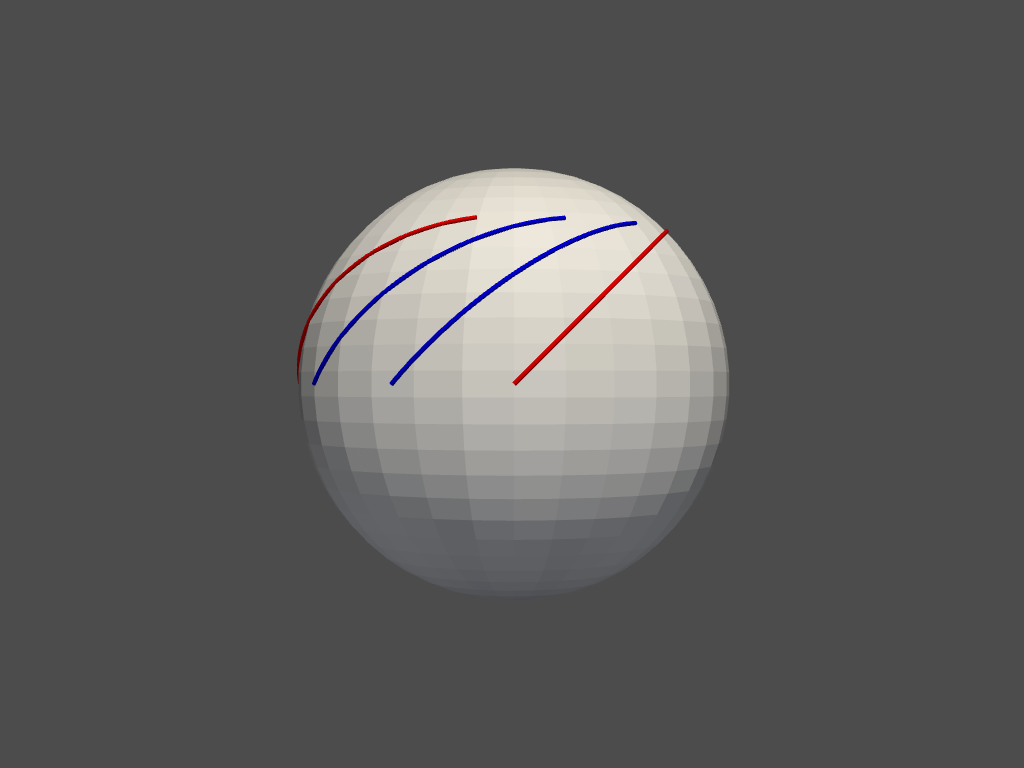

In [3]:
import numpy as np
import pyvista as pv

# print('Computing shortest path between geodesics')
z = TS2.connec.geodesic_discrete(pu0, puL)
geos0L, geos = [], []
geos0L.append(jax.vmap(lambda s: S2.connec.exp(p0, s * u0))(t))
geos0L.append(jax.vmap(lambda s: S2.connec.exp(pL, s * uL))(t))
for j in range(1, len(z) - 1):
    pj, uj = z[j][0], z[j][1]
    geos.append(jax.vmap(lambda s: S2.connec.exp(pj, s * uj))(t))

# create a tubular surface interpolating points
def tube_mesh(pts, interval=(0,2)):
    n = len(pts)-1
    curve = pv.PolyData(pts)
    curve["time"] = np.linspace(*interval, curve.n_points)
    curve.lines = np.c_[np.full(n,2), np.arange(n), np.arange(n)+1]
    curve.tube(radius=0.01, inplace=True)
    return curve

pl = pv.Plotter(notebook=True)
sphere = pv.Sphere(1)
tube1 = tube_mesh(np.asarray(geos0L[0]))
tube2 = tube_mesh(np.asarray(geos0L[1]))

pl.add_mesh(sphere)
pl.add_mesh(tube1, color='red')
pl.add_mesh(tube2, color='red')

for x in geos:
    tube = tube_mesh(np.asarray(x))
    pl.add_mesh(tube, color='blue')

pl.camera.zoom(1.2)
pl.view_yz()
pl.show(jupyter_backend='static')

Now we sample random geodesics using ```random_riemannian_normal``` and compute their (sample) Fréchet mean in $TM$. In the plot the data set is shown in red, while the mean geodesic is black; the mean of the underlying distribution is depicted in blue.

Computing mean of geodesics


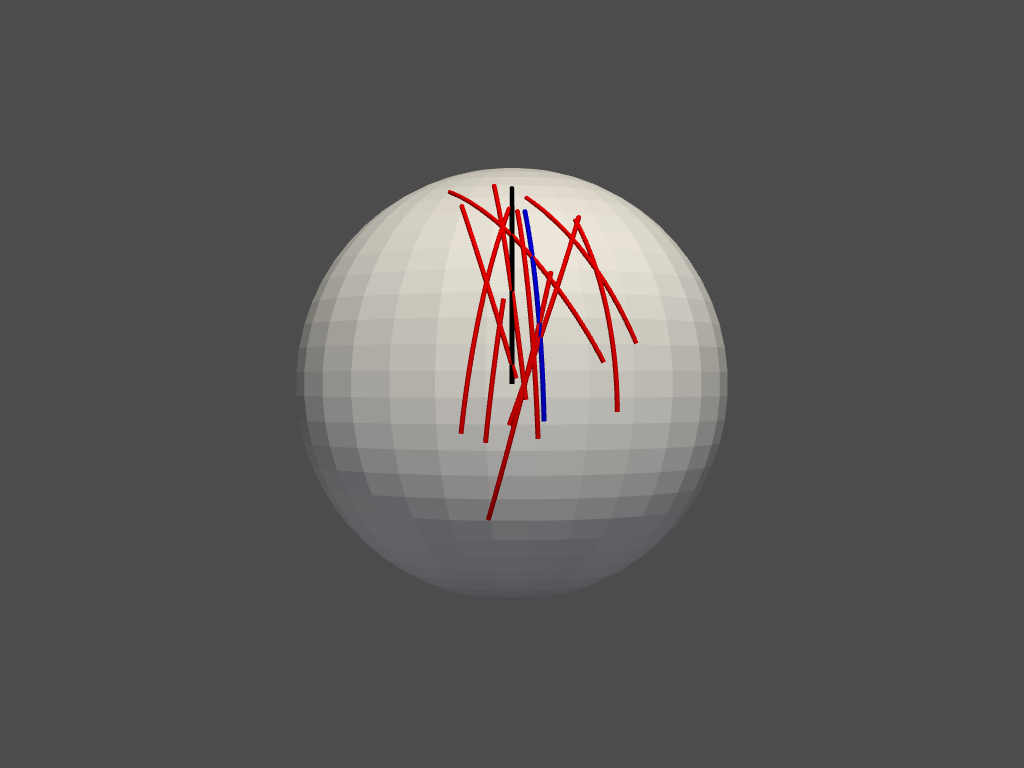

In [6]:
from geomstats.geometry.hypersphere import Hypersphere
from morphomatics.stats import ExponentialBarycenter

S2_help = Hypersphere(dim=2)
S2_help_metric = S2_help.metric
# Fix: #shape property of HypersphereMetric not initialized consistently
if S2_help.default_coords_type == 'extrinsic':
    S2_help_metric.shape = (S2.dim+1,)

m = jnp.array([[0, -1.0, 0], [0, 0, 1.0]])
n_samples, sigma = 10, jnp.pi/12
x = S2_help.random_riemannian_normal(m[0], n_samples=n_samples)
y = S2_help.random_riemannian_normal(m[0], n_samples=n_samples)
x = [S2_help_metric.exp(sigma*S2_help_metric.log(x[i], m[0]), m[0]) for i in range(n_samples)]
u = [m[1] + sigma*S2_help_metric.log(y[i], m[0]) for i in range(n_samples)]
samples = jnp.array([[x[i], u[i]] for i in range(n_samples)])

EB = ExponentialBarycenter()


def initial_mean(M: Manifold, pu):
    """
    Initialize mean geodesic
    """
    # compute mean of base points
    mean_p = EB.compute(M, pu[:, 0, :])
    # compute mean of tangent vectors
    PT = lambda p, u: M.connec.transp(p, mean_p, u)
    mean_v = np.mean([PT(*pu_i) for pu_i in pu], 0)
    return jnp.array([mean_p, mean_v])


print('Computing mean of geodesics')
initial = initial_mean(S2, np.asarray(samples))
mean = EB.compute(TS2, samples, x=initial)

data = []
meanvalue = jax.vmap(lambda s: S2.connec.exp(m[0], s * m[1]))(t)
geom = jax.vmap(lambda s: S2.connec.exp(mean[0], s * mean[1]))(t)
for sample in samples:
    data.append(jax.vmap(lambda s: S2.connec.exp(sample[0], s * sample[1]))(t))

pl = pv.Plotter(notebook=True)

sphere = pv.Sphere(1)
pl.add_mesh(sphere)

for d in data:
    pl.add_mesh(tube_mesh(np.asarray(d)), color='r')
pl.add_mesh(tube_mesh(np.asarray(meanvalue)), color='k')
pl.add_mesh(tube_mesh(np.asarray(geom)), color='blue')

pl.camera.zoom(1.2)
pl.view_xz()
pl.show(jupyter_backend='static')